In [1]:
import time

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

array_dims = tuple()

In [2]:
warmup_iters = 5 
bench_iters = 30

In [3]:
def transpose_method(array, mask):
    return jnp.where(mask, array.T, 0.0).T

In [4]:
def reshape_method(array, mask):
    return jnp.where(mask.reshape(-1, *(1,) * len(array.shape[1:])), array, 0.0)

In [5]:
methods = [transpose_method, reshape_method]

In [6]:
def benchmark(method, rng_key, size: int):
    @jax.jit
    def bench(array, mask):
        res = method(array, mask)
        return res.sum()

    # Warmup
    for _ in range(warmup_iters):
        array = jax.random.uniform(rng_key, (size, *array_dims))
        rng_key, key = jax.random.split(rng_key)
        mask = jax.random.choice(rng_key, jnp.array((True, False)), shape=(size,))
        bench(array, mask)

    results = []
    for _ in range(bench_iters):
        array = jax.random.uniform(rng_key, (size, *array_dims))
        rng_key, key = jax.random.split(rng_key)
        mask = jax.random.choice(rng_key, jnp.array((True, False)), shape=(size,))
        t0 = time.time()
        bench(array, mask)
        dt = time.time() - t0
        results.append(dt)

    return np.array(results)

In [7]:
results = {}
for method in methods:
    by_size = {}
    for size in (10, 100, 10_000, 100_000, 1_000_000):#, 10_000_000):
        rng_key = jax.random.key(0)
        by_size[size] = benchmark(method, rng_key, size)

    results[method.__name__] = by_size

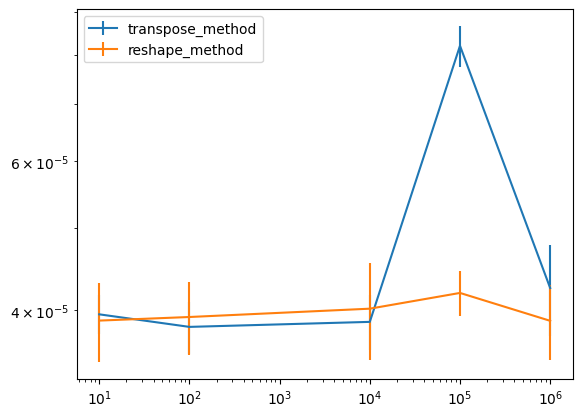

In [8]:
for name, by_size in results.items():
    sizes = []
    means = []
    stds = []
    for size, values in by_size.items():
        sizes.append(size)
        means.append(values.mean())
        stds.append(values.std())

    plt.errorbar(sizes, means, stds, label=name)

plt.yscale('log')
plt.xscale('log')
plt.legend()